#Project 2 NLA: SVD applications

By: Iris Vukovic

### Least Squares problem - QR vs SVD

#### a) Polynomial fitting

In [ ]:
import numpy as np
from scipy.linalg import svd
import matplotlib.pyplot as plt
import scipy.linalg as linalg
from scipy.linalg import qr
import scipy.ndimage
import imageio
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

First, we are initializing the datasets.

In [ ]:
!pip install striprtf

In [ ]:
#initialize x and y from 'datafile'

from striprtf.striprtf import rtf_to_text

file_path = '/content/datafile.rtf'

# Read the RTF file
with open(file_path, 'r') as file:
    rtf_content = file.read()

# Convert RTF to plain text
plain_text = rtf_to_text(rtf_content)

# Display the first 500 characters to understand the format
print(plain_text[:500])

3.5832421525945293e+00   1.7762943661477117e+01
  3.9437331727736704e+00   2.0051123245720245e+01
  1.8638039043315460e+00   6.7838796502053400e+00
  5.6402708084049884e+00   3.9128758254487387e+01
  2.2065644148051371e+00   7.4630844513126826e+00
  3.1582526343437962e+00   1.4176319792925534e+01
  4.5028814171580427e+00   2.5688020924310436e+01
  2.7547119133927684e+00   1.2437433385608255e+01
  2.9420477811376609e+00   1.2513790648521287e+01
  3.0909923850731507e+00   1.2762385170094607e+01
  


In [ ]:
# Split the text by lines
lines = plain_text.split('\n')

# Initialize lists to store x and y values
x_values = []
y_values = []

# Process each line
for line in lines:
    # Split by whitespace (you can adjust this depending on how the columns are separated)
    columns = line.split()
    if len(columns) == 2:
        x_values.append(float(columns[0]))  # Add x value
        y_values.append(float(columns[1]))  # Add y value

# Convert the lists to NumPy arrays
x = np.array(x_values)
y = np.array(y_values)

print(x[:5])
print(y[:5])

[3.58324215 3.94373317 1.8638039  5.64027081 2.20656441]
[17.76294366 20.05112325  6.78387965 39.12875825  7.46308445]


In [ ]:
print('x: ' ,x.shape)
print('y: ' ,y.shape)

x:  (500,)
y:  (500,)


Now, we will code an algorithm to polynomial fit our data points x and y, first using QR decomposition then using SVD decomposition.

####QR:

Polynomial coefficients (from QR decomposition): [0.20000039 1.31085632 0.98928421]


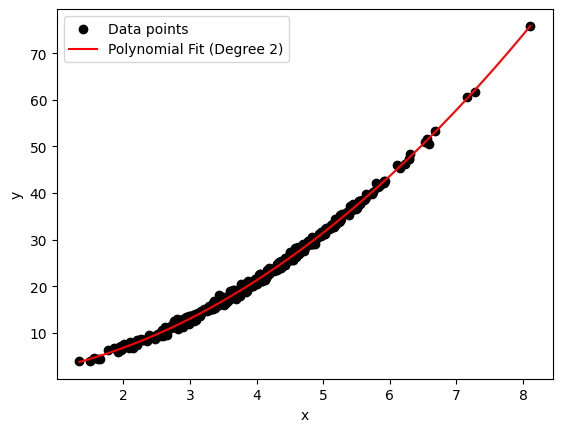

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to perform Gram-Schmidt orthogonalization on matrix A
def gram_schmidt(A):
    m, n = A.shape
    Q = np.zeros((m, n))
    R = np.zeros((n, n))

    for j in range(n):
        # Start with the current column of A
        v = A[:, j]

        # Subtract the projection onto all previous vectors
        for i in range(j):
            R[i, j] = np.dot(Q[:, i].T, v)
            v = v - R[i, j] * Q[:, i]

        # Normalize the vector
        R[j, j] = np.linalg.norm(v)
        Q[:, j] = v / R[j, j]

    return Q, R

# Function to perform polynomial fitting using QR decomposition
def polynomial_fit_qr(x, y, degree):
    m = len(x)

    # Construct the design matrix A for polynomial fitting manually
    A = np.zeros((m, degree + 1))
    for i in range(m):
        for j in range(degree + 1):
            A[i, j] = x[i] ** j  # Constructing the terms x^0, x^1, ..., x^degree

    # Perform QR decomposition using Gram-Schmidt
    Q, R = gram_schmidt(A)

    #Or with the numpy function which uses Householder reflections
    #Q, R = np.linalg.qr(A)


    # Solve R * x = Q.T * y
    Qt_b = np.dot(Q.T, y)  # Compute Q^T * y
    x_ls = np.linalg.solve(R, Qt_b)  # Solve the system R * x = Qt_b

    return x_ls

# Define the degree of the polynomial you want to fit (e.g., degree 2 for quadratic)
degree = 2

# Perform the polynomial fit using QR decomposition
coefficients = polynomial_fit_qr(x, y, degree)

# Output the polynomial coefficients
print("Polynomial coefficients (from QR decomposition):", coefficients)

# Plotting the data and the fitted polynomial
x_plot = np.linspace(min(x), max(x), 100)
A_plot = np.zeros((len(x_plot), degree + 1))

# Construct the design matrix for plotting the fitted curve
for i in range(len(x_plot)):
    for j in range(degree + 1):
        A_plot[i, j] = x_plot[i] ** j

# Compute the y-values of the fitted polynomial
y_fit = np.dot(A_plot, coefficients)

# Plot original data and the fitted curve
plt.scatter(x, y, color='black', label="Data points")
plt.plot(x_plot, y_fit, label=f"Polynomial Fit (Degree {degree})", color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


Below this I'm including the shape, rank, and condition number of the A matrix I constructed from my x values to justify that A is in fact well-conditioned and full rank (linearly-independent columns) which is why both Gram-Schmidt and the np.linalg.qr function (which uses Houeholder reflections) both work in this case for the QR factorization.

In [ ]:
print('shape A: ', A_plot.shape)
print('rank A: ',np.linalg.matrix_rank(A_plot))
cond_A = np.linalg.cond(A_plot)
print("Condition number of A:", cond_A)

shape A:  (100, 3)
rank A:  3
Condition number of A: 211.94772737815833


####SVD:

Polynomial coefficients (from SVD decomposition): [0.20000039 1.31085632 0.98928421]


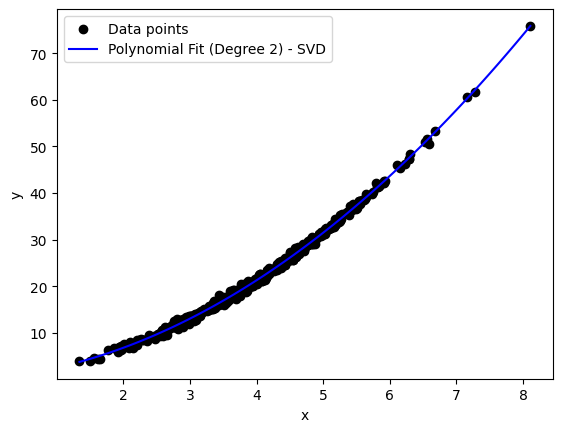

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to perform polynomial fitting using SVD decomposition with projection
def polynomial_fit_svd(x, y, degree):
    m = len(x)
    A = np.zeros((m, degree + 1))  # Initialize the matrix

    # Fill in the matrix
    for i in range(m):
        for j in range(degree + 1):
            A[i, j] = x[i] ** j  # x[i]^j, generating columns x^0, x^1, ..., x^degree

    #Perform SVD decomposition
    U, S, Vt = np.linalg.svd(A, full_matrices=False)  # SVD decomposition of A

    #Calculate the Moore-Penrose pseudo-inverse of A
    S_inv = np.diag(1 / S)  # Compute the pseudo-inverse of S (inverse of non-zero singular values)

    # Calculate the polynomial coefficients
    A_plus = np.dot(Vt.T, np.dot(S_inv, U.T))  # A^+ = V * S_inv * U^T
    coefficients_svd = np.dot(A_plus, y)

    return coefficients_svd

degree = 2

# Perform the polynomial fit using SVD decomposition
coefficients_svd = polynomial_fit_svd(x, y, degree)

# Output the polynomial coefficients
print("Polynomial coefficients (from SVD decomposition):", coefficients_svd)

# Plotting the data and the fitted polynomial
x_plot = np.linspace(min(x), max(x), 100)

# Manually construct the matrix for the plot
A_plot = np.zeros((len(x_plot), degree + 1))
for i in range(len(x_plot)):
    for j in range(degree + 1):
        A_plot[i, j] = x_plot[i] ** j  # x^0, x^1, ..., x^degree

# Compute the y-values of the fitted polynomial
y_fit_svd = np.dot(A_plot, coefficients_svd)

# Plot original data and the fitted curve
plt.scatter(x, y, color='black', label="Data points")
plt.plot(x_plot, y_fit_svd, label=f"Polynomial Fit (Degree {degree}) - SVD", color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


#### b) Rank-deficient Solution

Now we will solve a rank-deficient LS problem, first with QR decomposition, then with SVD decomposition.

In [ ]:
#Loading the data

file_path = '/content/dades_regressio.csv'  # Update with the correct path if different

# Load the data from the CSV file (assuming no headers)
data = np.loadtxt(file_path, delimiter=',')

# If the last column is the vector b and the rest is matrix A:
A = data[:, :-1]  # All rows, all columns except the last one
b = data[:, -1]   # Last column as the vector b

# Verify the shapes
print("Matrix A:")
print(A)
print(f"Shape of A: {A.shape}")

print("\nVector b:")
print(b)
print(f"Shape of b: {b.shape}")

Matrix A:
[[1.00000000e+00 1.00000000e+00 1.01010101e-02 1.02030405e-04
  1.03061015e-06 1.04102036e-08 1.05153571e-10 1.06215729e-12
  1.07288615e-14 1.08372338e-16 1.09467008e-18]
 [1.00000000e+00 1.00000000e+00 8.78787879e-01 7.72268136e-01
  6.78659877e-01 5.96398074e-01 5.24107398e-01 4.60579229e-01
  4.04751443e-01 3.55690662e-01 3.12576643e-01]
 [1.00000000e+00 1.00000000e+00 2.92929293e-01 8.58075707e-02
  2.51355510e-02 7.36293918e-03 2.15682057e-03 6.31795924e-04
  1.85071533e-04 5.42128734e-05 1.58805387e-05]
 [1.00000000e+00 1.00000000e+00 3.73737374e-01 1.39679625e-01
  5.22034960e-02 1.95103975e-02 7.29176473e-03 2.72520500e-03
  1.01851096e-03 3.80655611e-04 1.42265228e-04]
 [1.00000000e+00 1.00000000e+00 1.01010101e-02 1.02030405e-04
  1.03061015e-06 1.04102036e-08 1.05153571e-10 1.06215729e-12
  1.07288615e-14 1.08372338e-16 1.09467008e-18]
 [1.00000000e+00 1.00000000e+00 6.36363636e-01 4.04958678e-01
  2.57700977e-01 1.63991531e-01 1.04358247e-01 6.64097934e-02
  4.22

In [ ]:
print('A: ' ,A.shape)
print('b: ' ,b.shape)

print('rank A: ',np.linalg.matrix_rank(A))
cond_A = np.linalg.cond(A)
print("Condition number of A:", cond_A)

A:  (15, 11)
b:  (15,)
rank A:  10
Condition number of A: 5.6156276162279496e+16


Upon loading the data, we can tell by looking at the rank and the condition number of A that it is rank-deficient and ill-conditioned, thus we must include pivoting in our QR factorization.

####QR

In [ ]:
# Function to solve rank-deficient LS problem using QR with pivoting
def rank_deficient_ls_qr(A, b):
    # Perform QR decomposition with column pivoting
    Q, R, P = linalg.qr(A, mode='full', pivoting=True)
    P = np.eye(A.shape[1])[P]

    # Compute Qt * b (this is the new right-hand side)
    c_d = np.dot(Q.T, b)

    # Split c_d into c and d
    rank = np.linalg.matrix_rank(A)
    c = c_d[:rank]  # First rank of A elements
    d = c_d[rank:]  # Remaining elements (dependent part)

    # Solve for u using R1
    R1 = R[:10, :10]  # Non-singular part of R

    # Solve for u
    u = np.linalg.solve(R1, c)

    #set v = 0 for the basic solution
    v = np.zeros(A.shape[1] - rank)

    # The final solution is [u; v], where v = 0
    x_ls = np.dot(P.T, np.concatenate((u, v)))

    # Return the solution and the residual norm
    residual_norm = np.linalg.norm(b - np.dot(A, x_ls))

    return x_ls, residual_norm

# Solve the rank-deficient LS problem
x_ls, residual_norm = rank_deficient_ls_qr(A, b)

print("Least Squares Solution:", x_ls)
print()
print("Residual Norm:", residual_norm)

Least Squares Solution: [ 1.66061275e+01  0.00000000e+00 -1.88268350e+03  2.99498591e+04
 -2.12104358e+05  8.37034713e+05 -2.00324191e+06  2.97903439e+06
 -2.69206452e+06  1.35366101e+06 -2.90442987e+05]

Residual Norm: 1.1495978960493252


####SVD:

In [ ]:
def rank_deficient_ls_svd(A, b, tol=1e-10):
    #Perform SVD decomposition
    U, S, Vt = np.linalg.svd(A, full_matrices=False)

    #Create a diagonal matrix from the singular values S
    S_inv = np.zeros_like(S)

    # Only invert singular values larger than tolerance (thresholding small singular values)
    for i in range(len(S)):
        if S[i] > tol:
            S_inv[i] = 1 / S[i]

    #Solve the least squares problem using the SVD components
    x_ls = np.dot(Vt.T, np.dot(np.diag(S_inv), np.dot(U.T, b)))

    #Compute the residual norm
    residual_norm = np.linalg.norm(b - np.dot(A, x_ls))

    return x_ls, residual_norm

#Solve the rank-deficient least squares problem using SVD
x_ls_svd, residual_norm_svd = rank_deficient_ls_svd(A, b)

print("Least Squares Solution (from SVD):", x_ls_svd)
print()
print("Residual Norm (from SVD):", residual_norm_svd)

Least Squares Solution (from SVD): [ 8.30184540e+00  8.30428216e+00 -1.88268350e+03  2.99498592e+04
 -2.12104358e+05  8.37034713e+05 -2.00324191e+06  2.97903439e+06
 -2.69206453e+06  1.35366101e+06 -2.90442987e+05]

Residual Norm (from SVD): 1.14959789589875


The residual norms are close to equivalent, so both QR and SVD decomposition reach a solution that approximates the linear system about equally as well.

### Graphics compression

2) Obtaining a lossy compressed graphic image from a .jpeg file.

Note: I'm going to be using imageio.imread() in place of scipy.ndimage.imread() and imageio.imwrite() in place of scipy.misc.imsave() due to the scipy functions having been removed from the version of scipy I have installed.

<ipython-input-10-fe6e960e5375>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('/content/littleorangeguy.jpg')


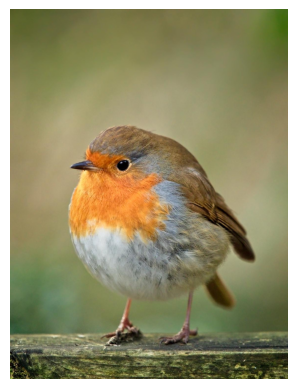

In [ ]:
img = imageio.imread('/content/littleorangeguy.jpg')

plt.imshow(img)
plt.axis('off')
plt.show()

<ipython-input-18-ee38289c9674>:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_path)


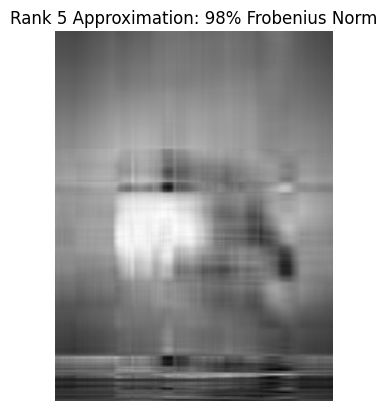

Saved compressed_images/5_approx_98_norm.jpeg with 98% Frobenius norm captured.


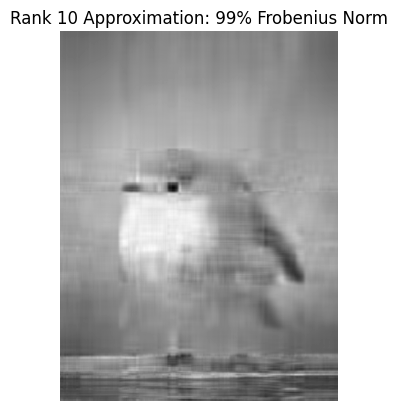

Saved compressed_images/10_approx_99_norm.jpeg with 99% Frobenius norm captured.


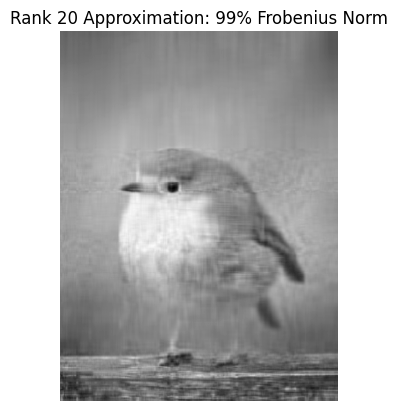

Saved compressed_images/20_approx_99_norm.jpeg with 99% Frobenius norm captured.


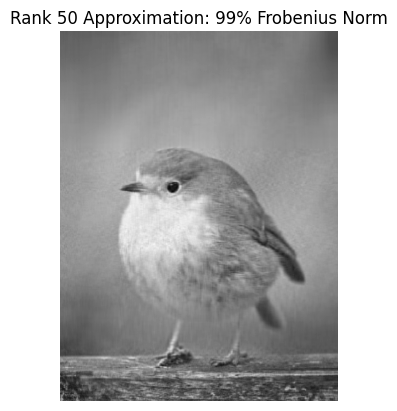

Saved compressed_images/50_approx_99_norm.jpeg with 99% Frobenius norm captured.


In [ ]:
# Function to perform SVD and return rank-k approximation
def svd_approximation(image_matrix, k):
    # Perform SVD
    U, S, Vt = np.linalg.svd(image_matrix, full_matrices=False)

    # Keep only the top k singular values
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    Vt_k = Vt[:k, :]

    # Rank-k approximation
    approx_image = np.dot(U_k, np.dot(S_k, Vt_k))

    return approx_image, np.sum(S[:k]**2) / np.sum(S**2)  # Return the approximation and Frobenius norm ratio

# Function to read image, convert to grayscale and compress using SVD
def compress_image(image_path, k_values):
    # Read the image
    img = imageio.imread(image_path)


    # Convert to grayscale
    if len(img.shape) == 3:
        img = img[..., 0]  # Extract only the Red channel for grayscale approximation

    img_matrix = np.array(img)

    # folder where compressed images are saved
    output_dir = 'compressed_images'
    os.makedirs(output_dir, exist_ok=True)

    # For each k value (rank of approximation)
    for k in k_values:
        # Get the rank-k approximation and Frobenius norm ratio
        approx_img, norm_ratio = svd_approximation(img_matrix, k)

        # Save the rank-k compressed image
        output_file = os.path.join(output_dir, f"{k}_approx_{int(norm_ratio * 100)}_norm.jpeg")
        imageio.imwrite(output_file, np.uint8(approx_img))

        # Display the compressed image
        plt.imshow(approx_img, cmap='gray')
        plt.title(f"Rank {k} Approximation: {int(norm_ratio * 100)}% Frobenius Norm")
        plt.axis('off')
        plt.show()

        print(f"Saved {output_file} with {int(norm_ratio * 100)}% Frobenius norm captured.")

image_path = '/content/littleorangeguy.jpg'
k_values = [5, 10, 20, 50]  # Different ranks for approximation
compress_image(image_path, k_values)


<ipython-input-20-3ac144840dd0>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('/content/babycrying.jpeg')


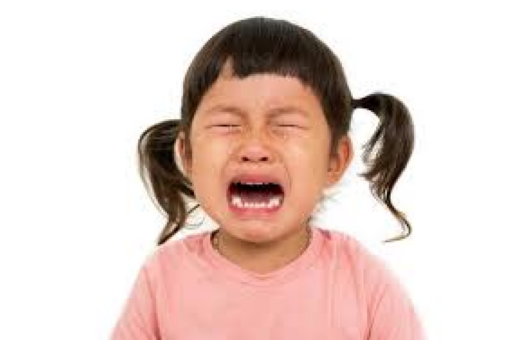

In [ ]:
img = imageio.imread('/content/babycrying.jpeg')

plt.imshow(img)
plt.axis('off')
plt.show()

<ipython-input-18-ee38289c9674>:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_path)


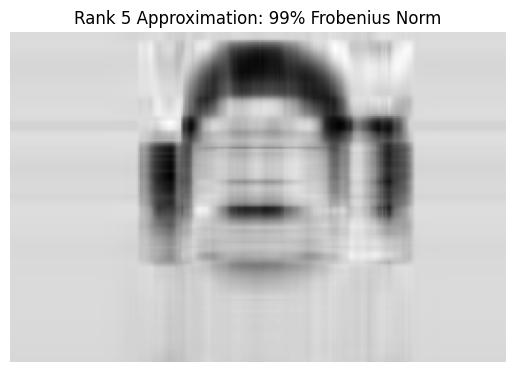

Saved compressed_images/5_approx_99_norm.jpeg with 99% Frobenius norm captured.


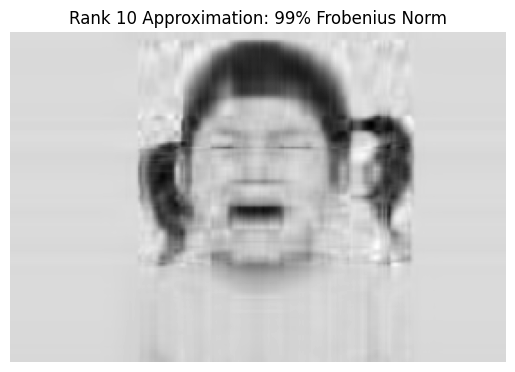

Saved compressed_images/10_approx_99_norm.jpeg with 99% Frobenius norm captured.


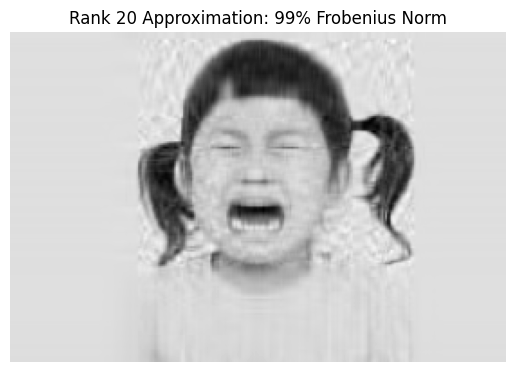

Saved compressed_images/20_approx_99_norm.jpeg with 99% Frobenius norm captured.


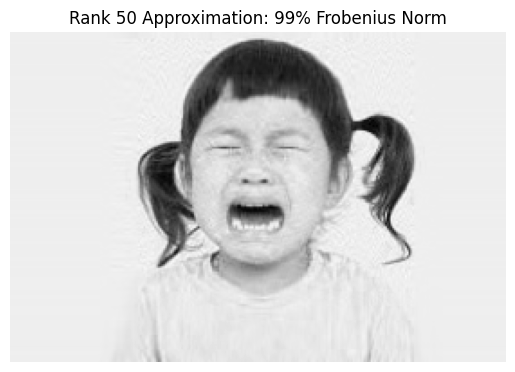

Saved compressed_images/50_approx_99_norm.jpeg with 99% Frobenius norm captured.


In [ ]:
image_path = '/content/babycrying.jpeg'
k_values = [5, 10, 20, 50]  # Different ranks for approximation
compress_image(image_path, k_values)

<ipython-input-21-c7f432c79d40>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('/content/streetsigns.jpeg')


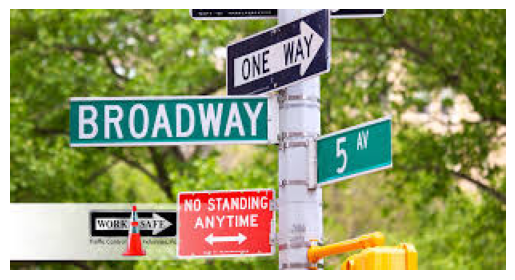

In [ ]:
img = imageio.imread('/content/streetsigns.jpeg')

plt.imshow(img)
plt.axis('off')
plt.show()

<ipython-input-18-ee38289c9674>:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_path)


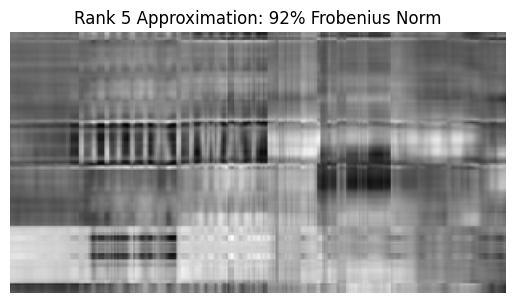

Saved compressed_images/5_approx_92_norm.jpeg with 92% Frobenius norm captured.


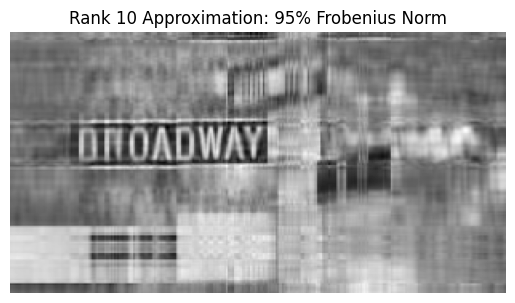

Saved compressed_images/10_approx_95_norm.jpeg with 95% Frobenius norm captured.


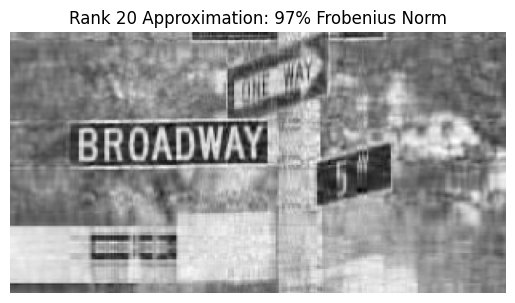

Saved compressed_images/20_approx_97_norm.jpeg with 97% Frobenius norm captured.


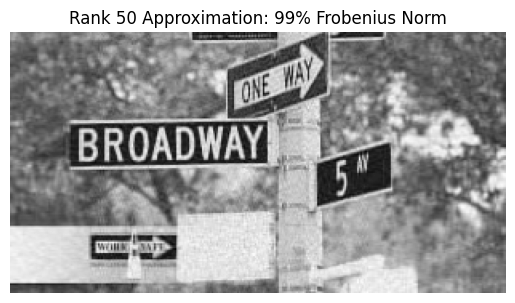

Saved compressed_images/50_approx_99_norm.jpeg with 99% Frobenius norm captured.


In [ ]:
image_path = '/content/streetsigns.jpeg'
k_values = [5, 10, 20, 50]  # Different ranks for approximation
compress_image(image_path, k_values)

### Principal component analysis (PCA)

####1) PCA analysis using covariance and correlation matrices
Using data from example.dat, we perform PCA analysis using the covariance matrix and then the correlation matrix.

In [ ]:
data = np.array([
    [6, 5, 3, 4],
    [7, 3, 2, 2],
    [6, 4, 4, 5],
    [5, 7, 1, 3],
    [7, 7, 5, 5],
    [6, 4, 2, 3],
    [5, 7, 2, 1],
    [6, 5, 4, 4],
    [3, 5, 6, 7],
    [1, 3, 7, 5],
    [2, 6, 6, 7],
    [5, 7, 7, 6],
    [2, 4, 5, 6],
    [3, 5, 6, 5],
    [1, 6, 5, 5],
    [2, 3, 7, 7]
])

print(data.shape)

(16, 4)


First and foremost, I performed PCA analysis on the covariance matrix using SVD decomposition to get the principal components from the columns of $V$ and the PCA coordinates from the dot product of $V^tX$ .

PCA using Covariance Matrix:
Eigenvalues (Variance captured by each principal component): [9.3240832  2.21170517 1.87267453 0.51237043]

Percentage of total variance captured by each principal component: [0.66979347 0.15887735 0.13452316 0.03680602]
1.0000000000000002

Standard Deviation of each principal component: [3.05353618 1.48718027 1.36845699 0.71580055]

Projected Data (PCA Coordinates): 
[[ 0.01941248  0.03666565 -0.03902089 -0.24654085]
 [ 1.27472503  0.65364646  0.00769348 -0.76960164]
 [-0.01754288  0.44816204 -0.37198387  0.44860939]
 [-0.02070618 -0.70708805  0.10777942 -1.4078307 ]
 [-1.41290592 -0.69653572  0.88801115  0.37994891]
 [ 0.79258638  0.36364678 -0.24297408 -0.67429104]
 [ 0.50893726 -0.91693959  1.25460577 -1.99193474]
 [-0.07408279 -0.00511311  0.3002513  -0.06694205]
 [-0.60316151  0.14904664 -0.57858127  0.9792874 ]
 [ 1.0577804   0.66807804 -0.19936824  0.35690182]
 [-0.77373081 -0.22498942 -0.42547175  0.69274659]
 [-1.51638589 -0.70565144  0.93208131  

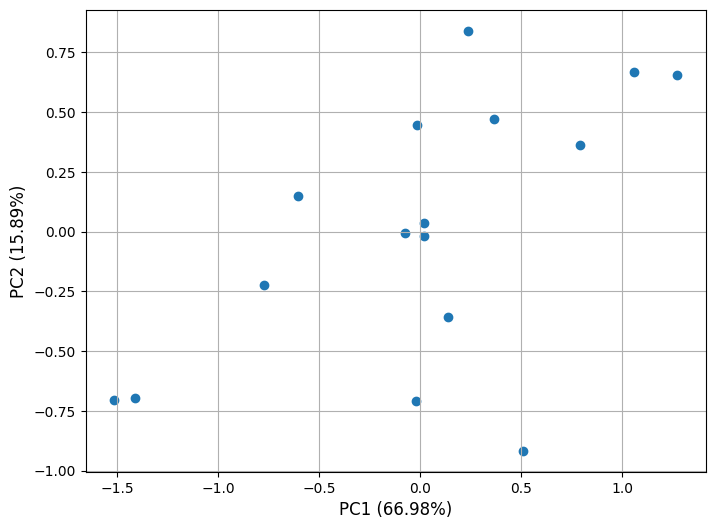

In [ ]:
#Center the data by subtracting the mean of each feature
data_centered = data - np.mean(data, axis=0)

#Compute Y = (1 / sqrt(n - 1)) * X^T
n_samples = data_centered.shape[0]
Y = data_centered.T / np.sqrt(n_samples - 1)

#Perform the reduced SVD of Y
U, S, Vt = np.linalg.svd(Y, full_matrices=False)

# Eigenvalues are the squared singular values
eigenvalues = S**2
eigenvectors = Vt.T

# Sort eigenvalues and corresponding eigenvectors (Vt) in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues_sorted = eigenvalues[sorted_indices]
eigenvectors_sorted = eigenvectors[sorted_indices]

# Calculate explained variance and standard deviations
explained_variance = eigenvalues_sorted / np.sum(eigenvalues_sorted)

# Standard deviation of each principal component (square root of eigenvalues)
std_dev = np.sqrt(eigenvalues_sorted)

# Project the data into the PCA space (new coordinates)
#pca_coordinates = np.dot(eigenvectors_sorted.T, data_centered)
pca_coordinates = np.dot(data_centered, eigenvectors_sorted)


# Print the sorted eigenvalues, eigenvectors, and PCA coordinates
print("PCA using Covariance Matrix:")
print(f"Eigenvalues (Variance captured by each principal component): {eigenvalues_sorted}")
print()
print(f"Percentage of total variance captured by each principal component: {explained_variance}")
print(sum(explained_variance))
print()
print(f"Standard Deviation of each principal component: {std_dev}")
print()
print(f"Projected Data (PCA Coordinates): \n{pca_coordinates}")
print()

# Create a scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(pca_coordinates[:, 0], pca_coordinates[:, 1])
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)', fontsize=12)
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)', fontsize=12)
plt.grid(True)
plt.show()


Here I'm checking my results with the covariance function. As you can see, the everything matches except the exact projected data is different which confuses me because how can everything be the same but the PCA coordinates differ?

PCA using Covariance Matrix:
Eigenvalues (Variance captured by each principal component): [9.3240832  2.21170517 1.87267453 0.51237043]

Percentage of total variance captured by each principal component: [0.66979347 0.15887735 0.13452316 0.03680602]
1.0

Standard Deviation of each principal component: [3.05353618 1.48718027 1.36845699 0.71580055]

Projected Data (PCA Coordinates): 
[[-2.33616589 -0.02763159 -0.6113487   0.42371803]
 [-4.35336868  2.12675047 -1.42283085 -0.37065439]
 [-1.10570266  0.24063832 -1.79814637  0.49789879]
 [-3.68471106 -0.48403484  2.14002302  1.05860044]
 [-1.42180965 -2.90827971 -1.20204912 -0.29523406]
 [-3.34953464  1.37262419 -0.50488667  0.39157212]
 [-4.11264074 -0.15458217  2.47946554 -1.08455516]
 [-1.73086512 -0.29514266 -0.92928776 -0.25522494]
 [ 2.81688024 -0.58975511 -0.43183679  0.73662089]
 [ 3.79757714  2.1654601   0.24020439 -1.26222463]
 [ 3.30409906 -1.04539952  0.81479819  0.76674108]
 [ 1.49693922 -2.98454685 -0.75368372 -0.81873847]
 [ 

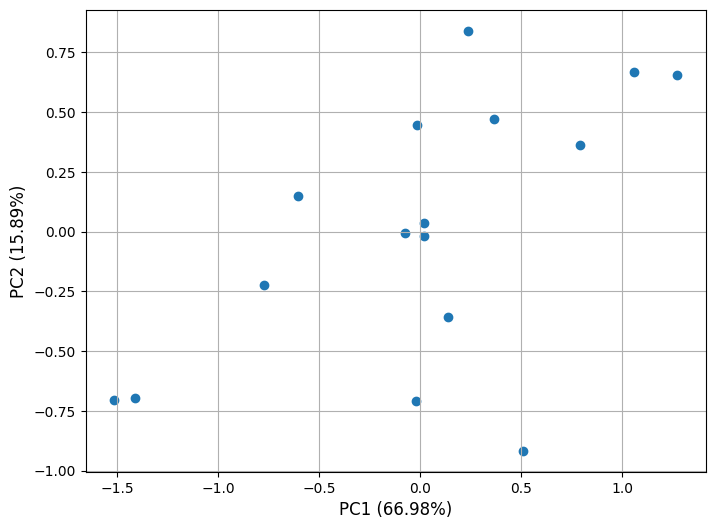

In [ ]:
#with covariance matrix
#Center the data by subtracting the mean
mean = np.mean(data, axis=0)
data_centered = data - mean

#Perform PCA using Covariance Matrix
cov_matrix = np.cov(data_centered, rowvar=False)
eigenvalues_cov, eigenvectors_cov = np.linalg.eigh(cov_matrix)

#Sort eigenvalues and eigenvectors in descending order to get priincipal components in order of importance
sorted_indices_cov = np.argsort(eigenvalues_cov)[::-1]
eigenvalues_cov_sorted = eigenvalues_cov[sorted_indices_cov]
eigenvectors_cov_sorted = eigenvectors_cov[:, sorted_indices_cov]

#Calculate proportion of variance explained by each principal component
explained_variance_cov = eigenvalues_cov_sorted / np.sum(eigenvalues_cov_sorted)
explained_variance_cov_cumsum = np.cumsum(explained_variance_cov)

#Standard deviation of each principal component (square root of eigenvalues)
std_dev_cov = np.sqrt(eigenvalues_cov_sorted)

#Project the data onto the principal components (PCA coordinates)
data_reduced_cov = np.dot(data_centered, eigenvectors_cov_sorted)

# Print results for Covariance Matrix PCA
print("PCA using Covariance Matrix:")
print(f"Eigenvalues (Variance captured by each principal component): {eigenvalues_cov_sorted}")
print()
print(f"Percentage of total variance captured by each principal component: {explained_variance_cov}")
print(sum(explained_variance_cov))
print()
print(f"Standard Deviation of each principal component: {std_dev_cov}")
print()
print(f"Projected Data (PCA Coordinates): \n{data_reduced_cov}")
print()

# Create a scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(pca_coordinates[:, 0], pca_coordinates[:, 1])
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)', fontsize=12)
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)', fontsize=12)
plt.grid(True)
plt.show()


Now, let's see how many principal components sufficiently explain the dataset.

Principal components retained by Kaiser rule (eigenvalue > 1): [ True  True  True False]


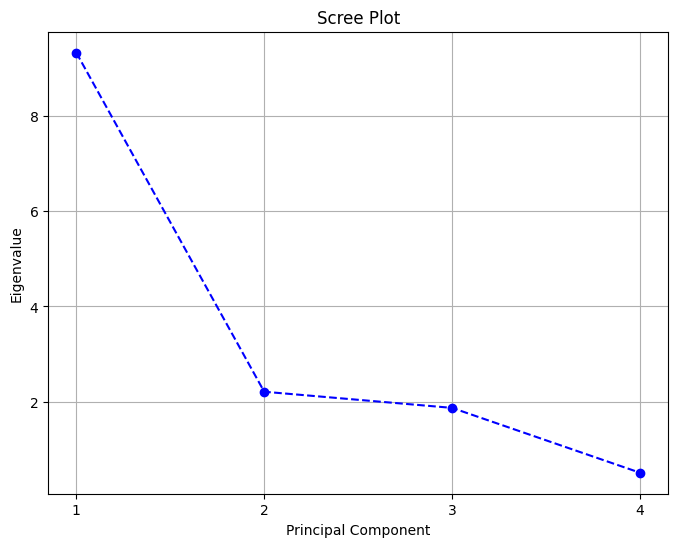

In [ ]:
# Kaiser Criterion
kaiser_rule = eigenvalues_sorted > 1
print(f"Principal components retained by Kaiser rule (eigenvalue > 1): {kaiser_rule}")

# Scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(eigenvalues_sorted) + 1), eigenvalues_sorted, marker='o', linestyle='--', color='b')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.xticks(range(1, len(eigenvalues_sorted) + 1))
plt.grid(True)
plt.show()

The Kaiser criterion indicates we can take 3 principal components, while the scree plot shows 2. Let's try to plot cumulative variance.

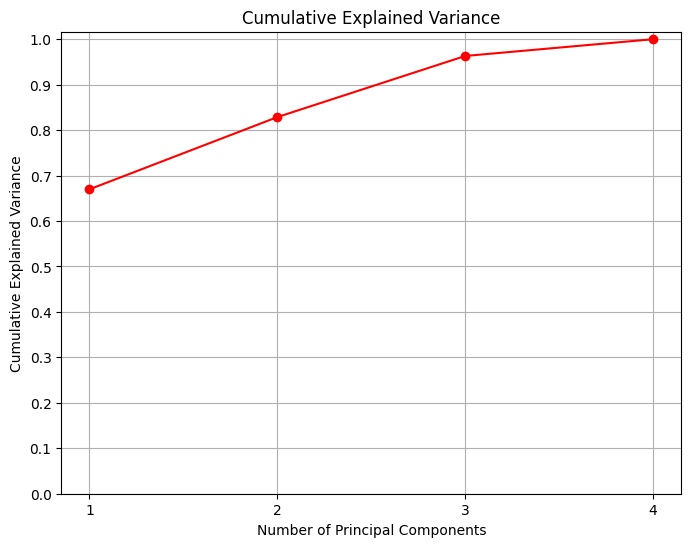

In [ ]:
cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', color='r')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(cumulative_explained_variance) + 1))
plt.yticks(np.linspace(0, 1, 11))
plt.grid(True)
plt.show()

It also indicates that 3 principal components would work. The different methods are in approximate agreeance.

Next, I do PCA analysis with the correlation matrix, again using SVD decomposition for the eigenvectors and eigenvalues. The only difference in comparison to using the covariance matrix is the way I normalize the data at the beginning.

PCA using Correlation Matrix:
Eigenvalues (Variance captured by each principal component): [2.59231039 1.02528235 0.49564837 0.15342555]

Percentage of total variance captured by each principal component: [0.60757275 0.24030055 0.11616759 0.03595911]
1.0

Standard Deviation of each principal component: [1.61006534 1.01256227 0.70402299 0.39169574]

Projected Data (PCA Coordinates): 
[[ 0.03466109  0.02326802  0.01454851  0.1522635 ]
 [ 0.84437424  0.47066995 -0.07507279  0.45663578]
 [ 0.04729695  0.38882404  0.09502275 -0.25809846]
 [-0.09680627 -0.54673592  0.08125371  0.81013196]
 [-0.78874266 -0.7054828  -0.34349884 -0.14714474]
 [ 0.4994608   0.30708937  0.07974535  0.38339536]
 [ 0.26209613 -0.91305079 -0.40719518  1.19616386]
 [ 0.00357394 -0.07159205 -0.14317532  0.06710953]
 [-0.37718733  0.22201215  0.22433807 -0.59176482]
 [ 0.63674886  0.55583608  0.00614257 -0.2394881 ]
 [-0.52710599 -0.07729583  0.21379368 -0.42941231]
 [-0.86831351 -0.70871411 -0.36900166 -0.40757069]
 [

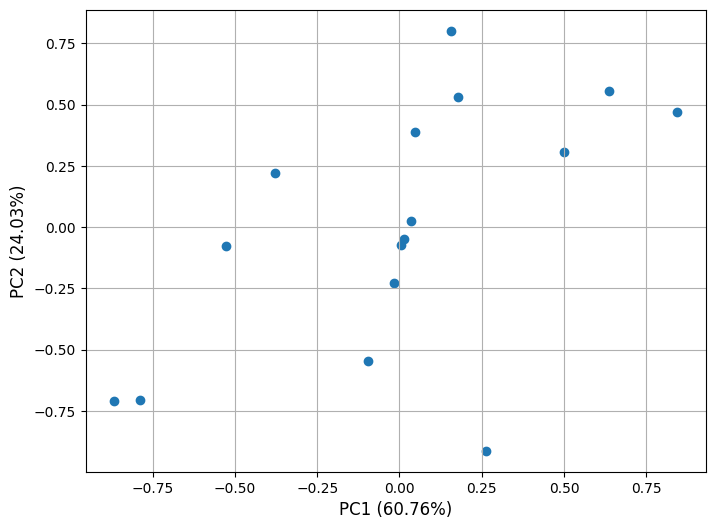

In [ ]:
#Standardize the data (center and scale)
mean = np.mean(data, axis=0)
std_dev = np.std(data, axis=0)
data_standardized = (data - mean) / std_dev  # Center and scale the data

#Compute Y = (1 / sqrt(n - 1)) * X^T
n_samples = data_standardized.shape[0]
Y = data_standardized.T / np.sqrt(n_samples - 1)

#Perform the reduced SVD of Y
U, S, Vt = np.linalg.svd(Y, full_matrices=False)

# Eigenvalues are the squared singular values
eigenvalues = S**2
eigenvectors = Vt.T

# Sort eigenvalues and corresponding eigenvectors (Vt) in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues_sorted = eigenvalues[sorted_indices]
eigenvectors_sorted = eigenvectors[sorted_indices]

# Calculate explained variance and standard deviations
explained_variance = eigenvalues_sorted / np.sum(eigenvalues_sorted)

# Standard deviation of each principal component (square root of eigenvalues)
std_dev = np.sqrt(eigenvalues_sorted)

# Project the data into the PCA space (new coordinates)
#pca_coordinates = np.dot(eigenvectors_sorted.T, data_centered)
pca_coordinates = np.dot(data_standardized, eigenvectors_sorted)


# Print the sorted eigenvalues, eigenvectors, and PCA coordinates
print("PCA using Correlation Matrix:")
print(f"Eigenvalues (Variance captured by each principal component): {eigenvalues_sorted}")
print()
print(f"Percentage of total variance captured by each principal component: {explained_variance}")
print(sum(explained_variance))
print()
print(f"Standard Deviation of each principal component: {std_dev}")
print()
print(f"Projected Data (PCA Coordinates): \n{pca_coordinates}")
print()

# Create a scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(pca_coordinates[:, 0], pca_coordinates[:, 1])
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)', fontsize=12)
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)', fontsize=12)
plt.grid(True)
plt.show()


Once again, I just wanted to compare my results with the correlation matrix function.

PCA using Correlation Matrix:
Eigenvalues: [2.43029099 0.96120221 0.46467035 0.14383645]

Percentage of total variance captured by each principal component: [0.60757275 0.24030055 0.11616759 0.03595911]
1.0
Standard Deviation of each principal component: [1.55893906 0.9804092  0.68166733 0.37925777]

Projected Data (PCA Coordinates): 
[[-1.14520929 -0.20585347 -0.35127392  0.22821265]
 [-2.13579331 -1.82692136 -0.28494506 -0.19505665]
 [-0.3753926  -0.72038791 -0.832809    0.25015836]
 [-2.09369303  0.91650704  0.7763731   0.61540022]
 [-0.69056863  1.39486696 -1.14474846 -0.19864877]
 [-1.66810444 -1.0528595  -0.03682508  0.22610387]
 [-2.46227084  0.7911549   1.11523239 -0.54624598]
 [-0.83716461 -0.13681365 -0.50364879 -0.15098459]
 [ 1.55237366  0.28114087 -0.31466795  0.38385788]
 [ 1.93639418 -1.21356043  0.677493   -0.6782424 ]
 [ 1.68175129  0.95800676  0.17906912  0.41379391]
 [ 0.76950876  1.62233387 -0.8747274  -0.48610976]
 [ 1.28231691 -0.5697695   0.40997484  0.4216036 ]


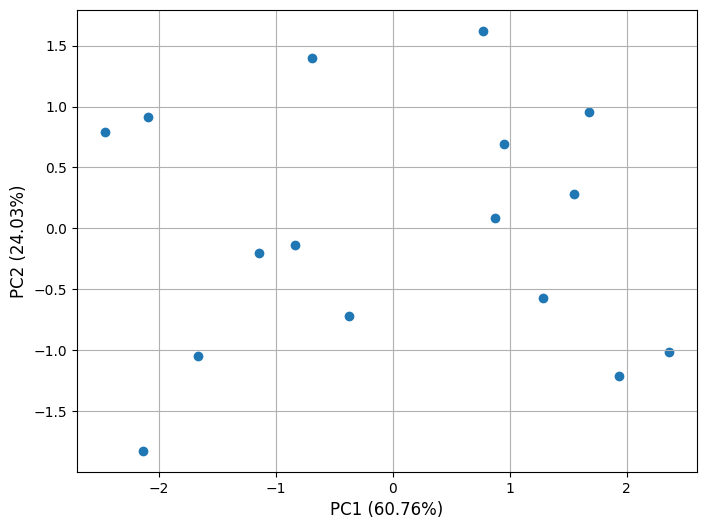

In [ ]:
#with correlation matrix
#Standardize the data (center and scale)
mean = np.mean(data, axis=0)
std_dev = np.std(data, axis=0)
data_standardized = (data - mean) / std_dev  # Center and scale the data

#Compute the correlation matrix
correlation_matrix = np.corrcoef(data_standardized, rowvar=False)

#Perform eigen-decomposition of the correlation matrix
eigenvalues_corr, eigenvectors_corr = np.linalg.eigh(correlation_matrix)

#Sort eigenvalues and eigenvectors in descending order
sorted_indices_corr = np.argsort(eigenvalues_corr)[::-1]
eigenvalues_corr_sorted = eigenvalues_corr[sorted_indices_corr]
eigenvectors_corr_sorted = eigenvectors_corr[:, sorted_indices_corr]

#Calculate the proportion of variance explained by each principal component
explained_variance_corr = eigenvalues_corr_sorted / np.sum(eigenvalues_corr_sorted)
explained_variance_corr_cumsum = np.cumsum(explained_variance_corr)

#Standard deviation of each principal component (square root of eigenvalues)
std_dev_corr = np.sqrt(eigenvalues_corr_sorted)

#Project the data onto the principal components (PCA coordinates)
data_reduced_corr = np.dot(data_standardized, eigenvectors_corr_sorted)

# Print results for Correlation Matrix PCA
print("PCA using Correlation Matrix:")
print(f"Eigenvalues: {eigenvalues_corr_sorted}")
print()
print(f"Percentage of total variance captured by each principal component: {explained_variance_corr}")
print(sum(explained_variance_corr))
print(f"Standard Deviation of each principal component: {std_dev_corr}")
print()
print(f"Projected Data (PCA Coordinates): \n{data_reduced_corr}")

# Create a scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(pca_coordinates[:, 0], pca_coordinates[:, 1])
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)', fontsize=12)
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)', fontsize=12)
plt.grid(True)
plt.show()



Let's see if the methods for choosing principal components tell us anything different now that we've done PCA analysis on the correlation matrix.

Principal components retained by Kaiser rule (eigenvalue > 1): [ True  True False False]


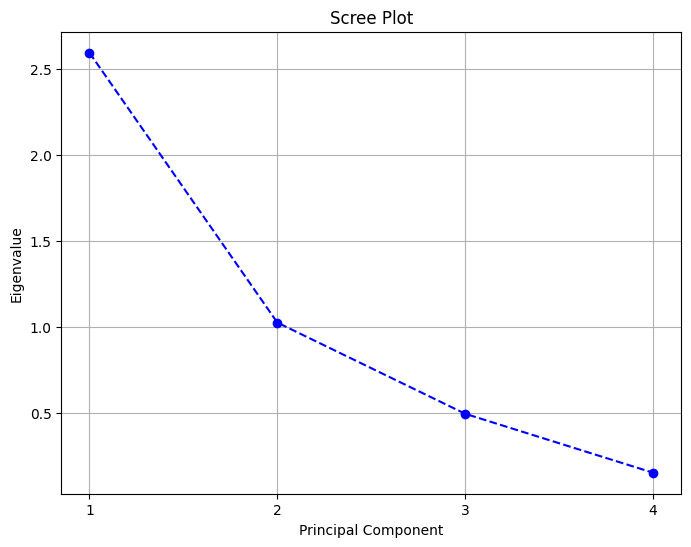

In [ ]:
# Kaiser Criterion
kaiser_rule = eigenvalues_sorted > 1
print(f"Principal components retained by Kaiser rule (eigenvalue > 1): {kaiser_rule}")

# Scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(eigenvalues_sorted) + 1), eigenvalues_sorted, marker='o', linestyle='--', color='b')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.xticks(range(1, len(eigenvalues_sorted) + 1))
plt.grid(True)
plt.show()

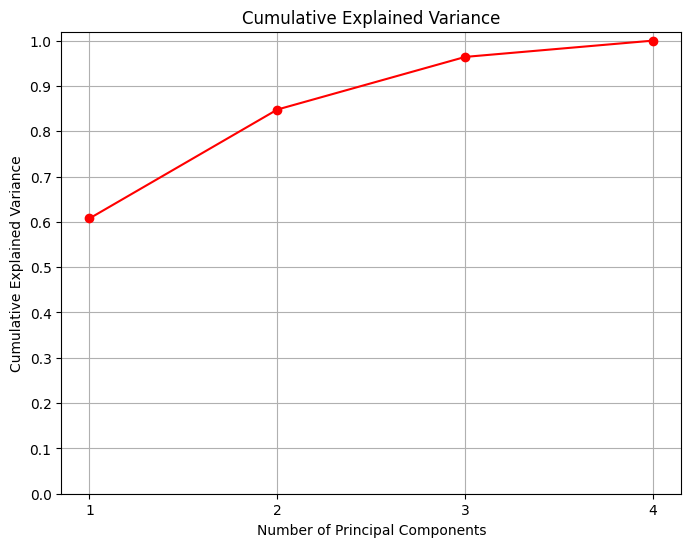

In [ ]:
cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', color='r')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(cumulative_explained_variance) + 1))
plt.yticks(np.linspace(0, 1, 11))
plt.grid(True)
plt.show()

This time, the Kaiser criterion and the Scree plot indicate that two principal components would suffice while the cumulative variance plot points to three. Relatively similar results though. The dataset is small so we don't have that many principal components in the first place. These methods are more useful for larger datasets where there are many principal components.

Correlation is preferred for data measured in different units because it normalizes it, whereas if it's all measured in the same units the standardization required to construct the correlation matrix might misconstrue the relationships between the variables. When data is all measured on the same scale, covariance matrix gives more interpretable results. This also explains why the principal components, variances, and standard deviations differ among the two matrices.

####2) PCA analysis on covariance matrix using data from mouse experiments

In [ ]:
file_path = '/content/RCsGoff.csv'
df = pd.read_csv(file_path)
print(df)

               gene  day0_rep1  day0_rep2  day0_rep3  day1_rep1  day1_rep2  \
0           DDX11L1          0          0          0          1          0   
1            WASH7P       1113        897       1498       2130       2047   
2         MIR6859-1          8          9         18         28         15   
3      RP11-34P13.3          0          0          0          3          4   
4         MIR1302-2          0          0          0          0          0   
...             ...        ...        ...        ...        ...        ...   
58576        MT-ND6          0          0          0          0          0   
58577         MT-TE          0          0          0          0          0   
58578        MT-CYB          0          0          0          0          0   
58579         MT-TT          0          0          0          0          0   
58580         MT-TP          0          0          0          0          0   

       day1_rep3  day2_rep1  day2_rep2  day2_rep3  ...  day4_re

(20, 58581)
(20, 20)


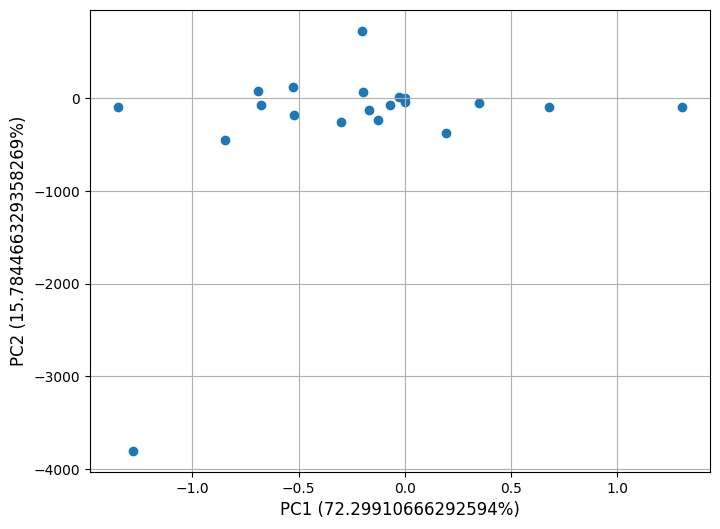

       day0_rep1   day0_rep2  day0_rep3   day1_rep1   day1_rep2   day1_rep3  \
PC1    -1.279891   -0.199895  -0.677770    0.193311   -0.848275   -0.300321   
PC2 -3800.697696  726.826456 -78.496648 -373.605747 -452.215180 -261.786007   
PC3   -37.813437   -2.682709 -10.366218   -2.032320   -8.249074   -1.822758   
PC4    -1.273290   -2.525437   3.102037   -1.424736    0.289575    4.737986   
PC5     0.000000    0.000000   0.000000    0.000000    0.000000    0.000000   

     day2_rep1   day2_rep2  day2_rep3   day4_rep1  ...  day4_rep3   day5_rep1  \
PC1   0.000752   -0.125595  -0.688800   -0.524747  ...   1.304450   -0.520316   
PC2 -44.523950 -232.267341  76.831631  119.311887  ... -97.149731 -178.502110   
PC3  -8.112646    1.754513  -8.176944    1.636004  ...  -0.737175    1.186942   
PC4   0.506320    0.487272  -0.455397    1.751650  ...  -0.567920    0.399048   
PC5   0.000000    0.000000   0.000000    0.000000  ...   0.000000    0.000000   

     day5_rep2  day11_rep1  day11_rep2

In [ ]:
# Center the data by subtracting the mean of each feature
data = df.iloc[:, 1:].values  # accesses all the numerical data
data_centered = data.T - np.mean(data.T, axis=0)

#Compute Y = (1 / sqrt(n - 1)) * X^T
n_samples = data_centered.shape[0]
Y = data_centered.T / np.sqrt(n_samples - 1)

#Perform the reduced SVD of Y
U, S, Vt = np.linalg.svd(Y, full_matrices=False)

# Eigenvalues are the squared singular values
eigenvalues = S**2
eigenvectors = Vt

# Sort eigenvalues and corresponding eigenvectors (Vt) in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues_sorted = eigenvalues[sorted_indices]
eigenvectors_sorted = eigenvectors[sorted_indices]

# Calculate explained variance
explained_variance = eigenvalues_sorted / np.sum(eigenvalues_sorted)

# Standard deviation of each principal component (square root of eigenvalues)
std_dev = np.sqrt(eigenvalues_sorted)

# Project the data into the PCA space (new coordinates)
#pca_coordinates = np.dot(eigenvectors_sorted.T, data_centered)
#pca_coordinates = np.dot(data_centered.T, eigenvectors_sorted)
pca_coordinates = np.dot(eigenvectors_sorted, data_centered)
print(pca_coordinates.shape)

#Prepare the output DataFrame with PC1 to PC20 and Variance
num_pcs = 20  # Number of principal components to use
#pca_coordinates = pca_coordinates.T[:, :num_pcs]  # Select the first 20 PCs
pca_coordinates = pca_coordinates[:, :num_pcs]  # Select the first 20 PCs

print(pca_coordinates.shape)

# Prepare the sample names (assuming 'Sample' is the index)
sample_names = df.columns[1:]

#Create the DataFrame with rows as samples and columns as PCs
#pca_df = pd.DataFrame(pca_coordinates, columns=[f'PC{i+1}' for i in range(num_pcs)], index=sample_names)
pca_df = pd.DataFrame(pca_coordinates.T, columns=sample_names, index=[f'PC{i+1}' for i in range(num_pcs)])

#Add the explained variance as a column for each PC
pca_df['Variance'] = explained_variance[:num_pcs]

#Save the result to a CSV file with the required format
output_filename = 'PCA_output.csv'
pca_df.to_csv(output_filename)

#Plot the first two principal components to compare with given plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_coordinates[:, 0], pca_coordinates[:, 1])
pc1_variance = explained_variance[0]
pc2_variance = explained_variance[1]
plt.xlabel(f'PC1 ({pc1_variance*100}%)', fontsize=12)
plt.ylabel(f'PC2 ({pc2_variance*100}%)', fontsize=12)

#plt.xlim(-1e6, 1.5e6)
#plt.ylim(-4e5, 4e5)
plt.grid(True)
plt.show()

# Print the resulting DataFrame
print(pca_df.head())
print(pca_df.shape)

Principal components retained by Kaiser rule (eigenvalue > 1): [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False]


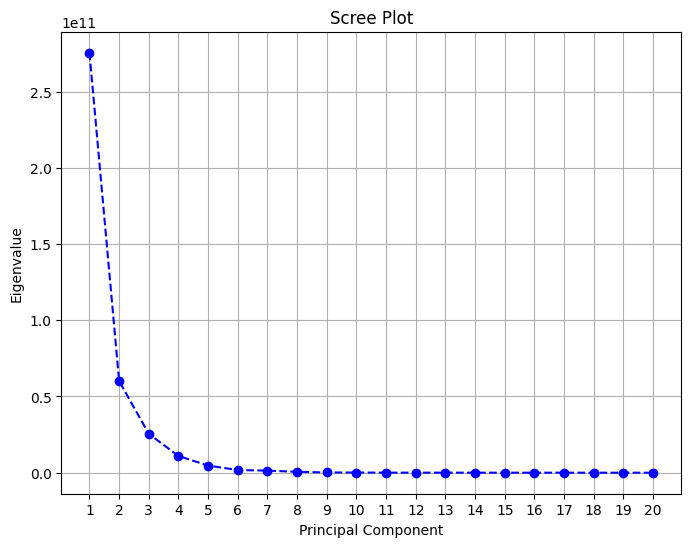

In [ ]:
# Kaiser Criterion
kaiser_rule = eigenvalues_sorted > 1
print(f"Principal components retained by Kaiser rule (eigenvalue > 1): {kaiser_rule}")

# Scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(eigenvalues_sorted) + 1), eigenvalues_sorted, marker='o', linestyle='--', color='b')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.xticks(range(1, len(eigenvalues_sorted) + 1))
plt.grid(True)
plt.show()

The Kaiser rule is giving us too many principal components (19), while the scree plot is indicating that 3 would suffice. Let's try the a cumulative variance plot.

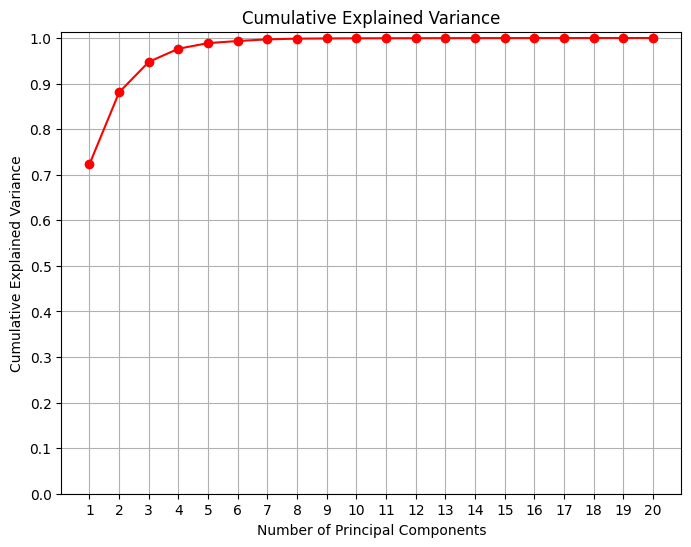

In [ ]:
cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', color='r')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(cumulative_explained_variance) + 1))
plt.yticks(np.linspace(0, 1, 11))
plt.grid(True)
plt.show()

It indicates around 4 principal components.